# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0
  ⋮
  1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0

### We create a function to visualize the data

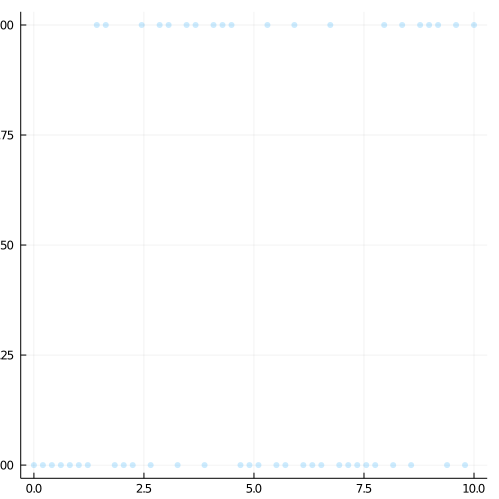

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.813118 seconds (1.16 M allocations: 67.522 MiB, 99.28% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:32
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:19
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:12
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:39
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:19
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:05
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-2.0752637781889613, -2.093865103057918, -2.0312673820902614, -1.8875760794141447, -1.6667664726976414, -1.448078092035931, -1.2568984485788413, -1.0435574467856983, -0.941908681133136, -0.8831034242068405  …  0.1006535963668774, 0.5554441058855037, 0.9536092880890329, 1.2317567957673354, 1.3395743574427215, 1.2478258447279758, 0.9612641538132761, 0.5139128773729974, 0.010019263054719285, -0.49599423813104276]]
 [[-0.8226309732847237, -0.69588272707749, -0.45219544955098323, -0.15052406286197195, 0.10158865329448452, 0.3177784989699448, 0.38199455946124405, 0.3375829223411998, 0.2062846744312189, 0.018015406222486707  …  0.3520231472705136, 0.3827891217400036, 0.3319709281192027, 0.14695779601629433, -0.06207727332962454, -0.3102193313648741, -0.5148332647150792, -0.6604386160498041, -0.7091021435914727, -0.6390673992782334]]
 [[0.2823741037405624, 0.24034722407268716, 0.15389535596014448, 0.054932031767290224, -0.10243529134102491, -0.2

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

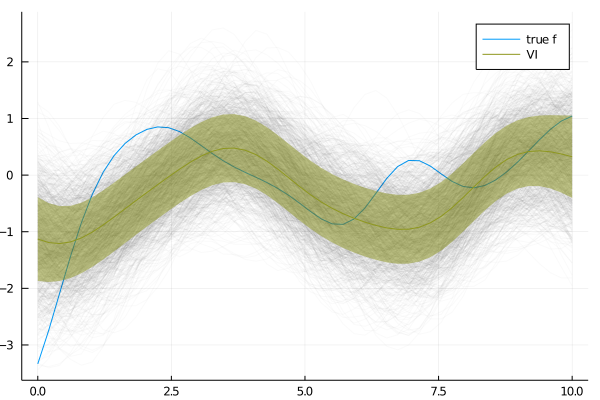

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

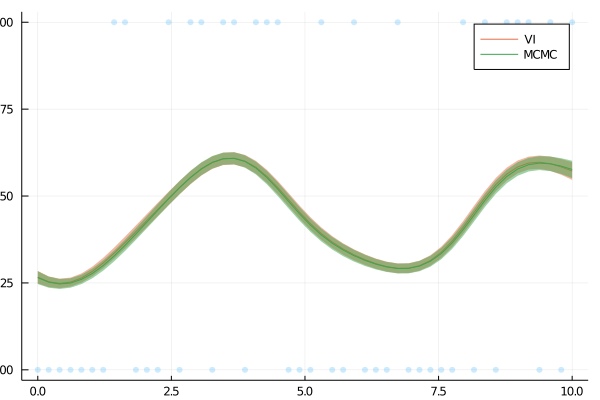

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*